### Investigating the Effect of Knocking Out the ACC1 Gene on Yarrowia lypoltica GSM iYLI647_corr.json
In this Jupyter notebook, we investigate the effect of knocking out the ACC1 gene ([Acetyl-CoA Carboxylase](https://www.genome.jp/entry/6.4.1.2)) on the growth rate of Yarrowia lypoltica genome scale model (GSM) iYLI647_corr [(Mishra 2018)](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-018-0542-5). ACC1 is an enzyme that catalyzes the reaction of acetyl-CoA, ATP, and hydrogencarbonate to form malonyl-CoA, ADP, and phosphate.

We test how the growth rate on glucose and [oleic acid](https://en.wikipedia.org/wiki/Oleic_acid) is affected by constraining the bounds of flux allowed through ACC1 from 100% of wildtype flux to 0%. For both substrates, the model was unable to produce biomass when ACC1 flux was constrained to 0%. 

Up to this, point the model was sufficient to perform these tasks without modification. Potentially the model is missing reactions that could be added, though. Spreadsheets were made with the all the reactions in the model that include either acety-CoA or malonyl-CoA to potentially help solve this problem.

In this notebook, we provide code and visualizations of the results of our investigation.



### Setup imports

In [12]:
import cobra
import pandas as pd

### Load model
This model was developed by [(Mishra 2018)](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-018-0542-5) and validated by [(Czajka 2021)](https://www.sciencedirect.com/science/article/pii/S1096717621001130#bib39).

In [13]:
# load model
model = cobra.io.json.load_json_model("../models/iYLI647_corr.json")
model

Name,model
Memory address,127133f70
Number of metabolites,1121
Number of reactions,1348
Number of genes,646
Number of groups,0
Objective expression,1.0*biomass_C - 1.0*biomass_C_reverse_c1d5c
Compartments,"c, e, m, n, x, r, g, v"


### Inspect Acetyl-CoA Carboxylase

In [14]:
model.reactions.get_by_id('ACCOACr')

Reaction identifier,ACCOACr
Name,acetyl CoA carboxylase reversible reaction
Memory address,0x12750cfa0
Stoichiometry,accoa[c] + atp[c] + hco3[c] <=> adp[c] + h[c] + malcoa[c] + pi[c] Acetyl_CoA + ATP + Bicarbonate <=> ADP + H + Malonyl_CoA + Phosphate
GPR,YALI0C11407g
Lower bound,-1000.0
Upper bound,1000.0


### Inspect Oleic Acid C<sub>18</sub>H<sub>34</sub>O<sub>2</sub>

In [15]:
oleic_acid = model.metabolites.get_by_id('ocdcea[e]')
oleic_acid

Metabolite identifier,ocdcea[e]
Name,octadecenoate__n_C181_
Memory address,0x12664b760
Formula,C18H33O2
Compartment,e
In 3 reaction(s),"exlip, OCDCEAt, EX_ocdcea(e)"


### Inspect the model's objective function (maximize biomass flux)

In [16]:
model.objective.expression

1.0*biomass_C - 1.0*biomass_C_reverse_c1d5c

### Inspect the model's default media 
The trahalose reaction in the media object has no effect so it is excluded throughout this notebook.

In [17]:
model.medium

{'EX_glc(e)': 10.0,
 'EX_h2o(e)': 1000.0,
 'EX_h(e)': 1000.0,
 'EX_nh4(e)': 1000.0,
 'EX_o2(e)': 1000.0,
 'EX_pi(e)': 1000.0,
 'EX_so4(e)': 1000.0,
 'trehalose_c_tp': 1000.0}

### Identify metabolites that the model can consume/exchange reactions

In [18]:
# filter the model's reactions to only include exchange reactions
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]

# get the metabolites involved in the exchange reactions
exchange_metabolites = [reaction.reactants[0]for reaction in exchange_reactions]

# create a dataframe of metabolites that can be exchanged
exchange_metabolite_data = []
for metabolite in exchange_metabolites:
    exchange_metabolite_data.append({
    'id': metabolite.id,
    'name': metabolite.name,
    'formula': metabolite.formula,
    'formula_weight': metabolite.formula_weight,
  })

# save as exchange metabolites as a csv
pd.DataFrame(exchange_metabolite_data).to_csv('../data/exchange_metabolites.csv', index=False)

pd.DataFrame(exchange_metabolite_data).head()


/Users/garrettroell/yarrowia_gsm/yarrowia_lipid_substrate_gsm/venv/lib/python3.10/site-packages/cobra/core/metabolite.py:191: UserWarning: The element 'R' does not appear in the periodic table
  warn(f"The element {e} does not appear in the periodic table")


,id,name,formula,formula_weight
0,13BDglcn[e],1_3_beta_D_Glucan,C6H10O5,162.14060
1,4abut[e],4_Aminobutanoate,C4H9NO2,103.11976
2,5aop[e],5_Amino_4_oxopentanoate,C5H9NO3,131.12986
3,8aonn[e],8_Amino_7_oxononanoate,C9H17NO3,187.23618
4,abt[e],L_Arabinitol,C5H12O5,152.14578


### Make graph of ACC1 flux vs growth rate for glucose

10.0 EX_glc(e)
1000.0 EX_h2o(e)
1000.0 EX_h(e)
1000.0 EX_nh4(e)
1000.0 EX_o2(e)
1000.0 EX_pi(e)
1000.0 EX_so4(e)


,fraction_blocked,biomass_flux
0,0.0,1.139817
1,0.1,1.025835
2,0.2,0.911853
3,0.3,0.797872
4,0.4,0.683890
5,0.5,0.569908
6,0.6,0.455927
7,0.7,0.341945
8,0.8,0.227963
9,0.9,0.113982


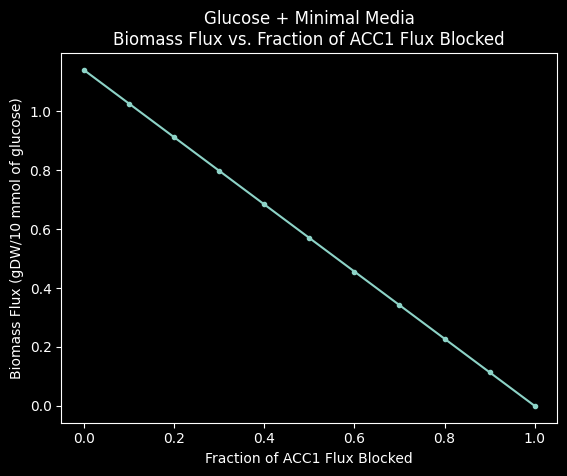

In [19]:
# minimal medium with glucose as sole carbon source
model.medium = {
  'EX_glc(e)': 10.0, # 10 mmol of glucose
  'EX_h2o(e)': 1000.0,
  'EX_h(e)': 1000.0,
  'EX_nh4(e)': 1000.0,
  'EX_o2(e)': 1000.0,
  'EX_pi(e)': 1000.0,
  'EX_so4(e)': 1000.0,
}

growth_rates = []
  
with model:
  # update the model to use the specified medium
  medium = model.medium
  [print(model.medium[m], m) for m in model.medium]

  # calculate maximum biomass flux and ACC1 flux in that solution
  solution = model.optimize()
  acc1_flux = solution['ACCOACr']

  # block increasing amounts [0, 0.1, 0.2, ... 1.0] of the flux through ACC1
  for fraction_blocked in [i / 10 for i in range(0, 11)]:

    model.reactions.get_by_id('ACCOACr').bounds = (-acc1_flux * (1 - fraction_blocked), acc1_flux * (1 - fraction_blocked))

    # calculate maximum biomass flux given the new ACC1 max flux value
    solution = model.optimize()

    # store data for plotting
    growth_rates.append({
      'fraction_blocked': fraction_blocked,
      'biomass_flux': solution.objective_value,
    })

    # plot the results
  growth_rates_df = pd.DataFrame(growth_rates)
  growth_rates_df.plot(
    x='fraction_blocked', 
    y='biomass_flux', 
    title='Glucose + Minimal Media\nBiomass Flux vs. Fraction of ACC1 Flux Blocked', 
    xlabel='Fraction of ACC1 Flux Blocked', 
    ylabel='Biomass Flux (gDW/10 mmol of glucose)', 
    style='.-', 
    legend=False
  )

pd.DataFrame(growth_rates)



### Make graph of ACC1 flux vs growth rate for oleic acid

1000.0 EX_h2o(e)
1000.0 EX_h(e)
1000.0 EX_nh4(e)
1000.0 EX_o2(e)
10.0 EX_ocdcea(e)
1000.0 EX_pi(e)
1000.0 EX_so4(e)


,fraction_blocked,biomass_flux
0,0.0,2.957317
1,0.1,2.661590
2,0.2,2.365858
3,0.3,2.070126
4,0.4,1.774393
5,0.5,1.478661
6,0.6,1.182929
7,0.7,0.887197
8,0.8,0.591464
9,0.9,0.295732


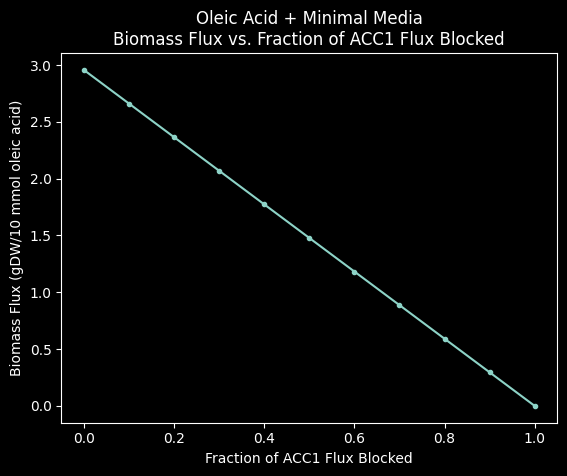

In [20]:
# minimal medium with oleic as sole carbon source
model.medium = {
  'EX_ocdcea(e)' : 10.0, # 10 mmol of oleic acid
  'EX_h2o(e)': 1000.0,
  'EX_h(e)': 1000.0,
  'EX_nh4(e)': 1000.0,
  'EX_o2(e)': 1000.0,
  'EX_pi(e)': 1000.0,
  'EX_so4(e)': 1000.0,
}

growth_rates = []
  
with model:
  # update the model to use the specified medium
  medium = model.medium
  [print(model.medium[m], m) for m in model.medium]

  # calculate maximum biomass flux and ACC1 flux in that solution
  solution = model.optimize()
  acc1_flux = solution['ACCOACr']

  # block increasing amounts [0, 0.1, 0.2, ... 1.0] of the flux through ACC1
  for fraction_blocked in [i / 10 for i in range(0, 11)]:

    model.reactions.get_by_id('ACCOACr').bounds = (-acc1_flux * (1 - fraction_blocked), acc1_flux * (1 - fraction_blocked))

    # calculate maximum biomass flux given the new ACC1 max flux value
    solution = model.optimize()

    # store data for plotting
    growth_rates.append({
      'fraction_blocked': fraction_blocked,
      'biomass_flux': solution.objective_value,
    })

    # plot the results
  growth_rates_df = pd.DataFrame(growth_rates)
  growth_rates_df.plot(
    x='fraction_blocked', 
    y='biomass_flux', 
    title='Oleic Acid + Minimal Media\nBiomass Flux vs. Fraction of ACC1 Flux Blocked', 
    xlabel='Fraction of ACC1 Flux Blocked', 
    ylabel='Biomass Flux (gDW/10 mmol oleic acid)', 
    style='.-', 
    legend=False
  )

pd.DataFrame(growth_rates)



### Make a file of the reactions that include Acetyl-CoA

In [21]:
accoa_reactions = [reaction for reaction in model.reactions if 'accoa' in reaction.reaction]

# create a dataframe of metabolites that can be exchanged
accoa_reactions_data = []
for reaction in accoa_reactions:
    accoa_reactions_data.append({
    'id': reaction.id,
    'name': reaction.name,
    'reaction': reaction.reaction,
    'lower_bound': reaction.lower_bound,
    'upper_bound': reaction.upper_bound,
    'gpr': reaction.gene_reaction_rule,
    'compartments': reaction.get_compartments(),
  })

# save as exchange metabolites as a csv
pd.DataFrame(accoa_reactions_data).to_csv('../data/accoa_reactions.csv', index=False)

pd.DataFrame(accoa_reactions_data).head()


,id,name,reaction,lower_bound,upper_bound,gpr,compartments
0,ACACT1m,acetyl CoA C acetyltransferase mitochondrial,2.0 accoa[m] <=> aacoa[m] + coa[m],-1000.0,1000.0,YALI0B08536g and YALI0E11099g,[m]
1,ACACT4p,acetyl CoA C acetyltransferase octanoyl CoA pe...,3odcoa[x] + coa[x] --> accoa[x] + occoa[x],0.0,1000.0,YALI0E18568g,[x]
2,ACACT5p,acetyl CoA C acyltransferase decanoyl CoA pero...,3oddcoa[x] + coa[x] --> accoa[x] + dcacoa[x],0.0,1000.0,YALI0E18568g,[x]
3,ACACT6p,acetyl CoA C acetyltransferase dodecanoyl pero...,3otdcoa[x] + coa[x] --> accoa[x] + ddcacoa[x],0.0,1000.0,YALI0E18568g,[x]
4,ACACT7p,acetyl CoA acyltransferase tetradecanoyl CoA p...,3ohdcoa[x] + coa[x] --> accoa[x] + tdcoa[x],0.0,1000.0,YALI0E18568g,[x]


### Make a file of the reactions that include Malonyl-CoA

In [22]:
malcoa_reactions = [reaction for reaction in model.reactions if 'malcoa' in reaction.reaction]

len(malcoa_reactions)

# create a dataframe of metabolites that can be exchanged
malcoa_reactions_data = []
for reaction in malcoa_reactions:
    malcoa_reactions_data.append({
    'id': reaction.id,
    'name': reaction.name,
    'reaction': reaction.reaction,
    'lower_bound': reaction.lower_bound,
    'upper_bound': reaction.upper_bound,
    'gpr': reaction.gene_reaction_rule,
    'compartments': reaction.get_compartments(),
  })

# save as exchange metabolites as a csv
pd.DataFrame(malcoa_reactions_data).to_csv('../data/malcoa_reactions.csv', index=False)

pd.DataFrame(malcoa_reactions_data).head()


,id,name,reaction,lower_bound,upper_bound,gpr,compartments
0,ACCOACr,acetyl CoA carboxylase reversible reaction,accoa[c] + atp[c] + hco3[c] <=> adp[c] + h[c] ...,-1000.0,1000.0,YALI0C11407g,[c]
1,FAS100COA,fatty acyl CoA synthase n C100CoA,3.0 h[c] + malcoa[c] + 2.0 nadph[c] + occoa[c]...,0.0,1000.0,YALI0B15059g and YALI0B19382g and YALI0C11407g...,[c]
2,FAS120COA,fatty acyl CoA synthase n C120CoA,dcacoa[c] + 3.0 h[c] + malcoa[c] + 2.0 nadph[c...,0.0,1000.0,YALI0B15059g and YALI0B19382g and YALI0C11407g...,[c]
3,FAS140COA,fatty acyl CoA synthase n C140CoA,ddcacoa[c] + 3.0 h[c] + malcoa[c] + 2.0 nadph[...,0.0,1000.0,YALI0B15059g and YALI0B19382g and YALI0C11407g...,[c]
4,FAS160COA,fatty acyl CoA synthase n C160CoA,3.0 h[c] + malcoa[c] + 2.0 nadph[c] + tdcoa[c]...,0.0,1000.0,YALI0B15059g and YALI0B19382g and YALI0C11407g...,[c]
